# Import packages

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta
import contextily as cx
import numpy as np
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.dates as mdates
from matplotlib import animation
from shapely import box
import imageio
import xarray as xr

from hydromt_sfincs import SfincsModel, utils
from hydromt.log import setuplog

In [3]:
root_project = '/Users/aprida/Documents/Consulting/Private_sector/Keolis'

# Functions

# Read model

The package *hydromt_sfincs* provides functions to read two types of output files:

- **sfincs_his.nc**: This file provides the results at predefined observation points (1D results).
- **sfincs_map.nc**: This file provides the results for the entire 2D computational mesh (2D results).

In [6]:
# Set paths to model components

root = '/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline'
logger = setuplog(root, log_level = 10)
data_libs = 'Inputs/data_catalog.yml' # Data catalog path

# Read model

sf = SfincsModel(root=root, mode="r", data_libs=data_libs, logger=logger) # Open model in read mode to read results
print(f'\n\n Output files: {list(sf.results.keys())}')

# Create folder to store Output files

output_path = os.path.join(root,'output')
os.makedirs(output_path, exist_ok=True)

2024-11-25 16:42:16,721 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline - log - INFO - HydroMT version: 0.8.0
2024-11-25 16:42:16,725 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline - data_catalog - INFO - Parsing data catalog from Inputs/data_catalog.yml
2024-11-25 16:42:16,741 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline - log - DEBUG - Appending log messages to file /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline/hydromt.log.
2024-11-25 16:42:16,742 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.1).


 Output files: ['inp', 'msk', 'zb', 'zs', 'zsmax', 'total_runtime', 'average_dt', 'point_zb', 'point_zs', 'crosssection_discharge']


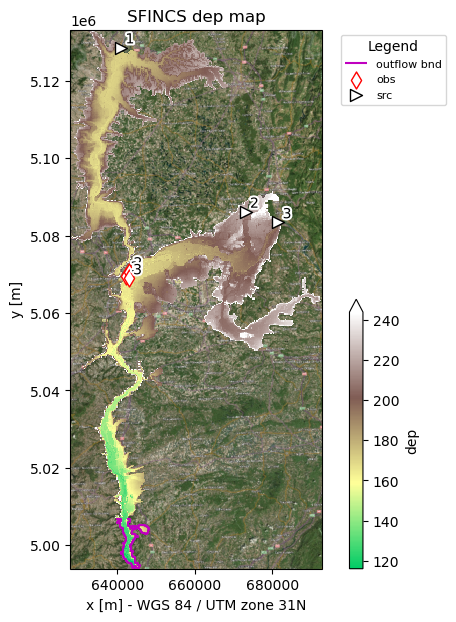

In [10]:
# plot the model layout
fig, ax = sf.plot_basemap(fn_out=None, bmap="sat", figsize=(7,7))

# Plot output timeseries at observation points (1D results)

Output timeseries at points are stored at 'point*' output files (e.g. 'point_zb' as ground elevation, 'point_zs' as water elevation).

# Plot output timeseries at observation lines (1D results)

Output timeseries at lines are stored at 'crosssection_discharge' output file (discharge).

# Plot output flood maps at computational domain (2D results)

In [23]:
ds_depth = sf.results['zs'] - sf.results['zb']
ds_depth.to_netcdf('/Users/aprida/Desktop/FL_rp1000_baseline.nc')

Text(0.5, 1.0, 'Maximum flood depth across area of interest')

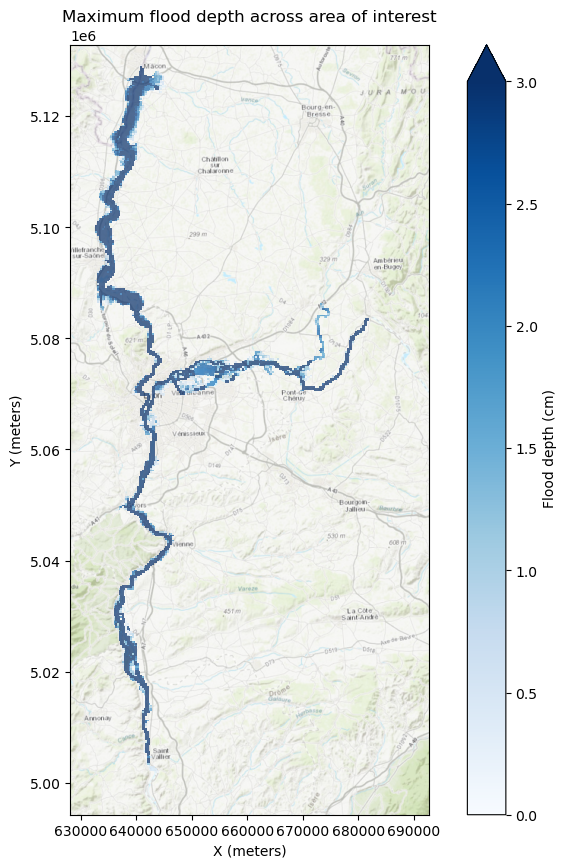

In [11]:
# Compute maximum flood depth for the simulated event across area of interest

max_depth = sf.results['zsmax'].max(dim='timemax') - sf.results['zb'] # Max flood depth (for simulated event) is equal to max water elevation minus ground elevation
max_depth.rio.to_raster(os.path.join(output_path, f'flood_max_{root.split("/")[-1]}.tif')) # Save max flood depth raster to file

# Plot flood map without removing and removing surface water bodies

fig, ax = plt.subplots(figsize=(10, 10))

max_depth.plot(ax=ax,
               cmap='Blues', cbar_kwargs={"label": "Flood depth (cm)"},
               vmin=0, vmax=3,
               alpha=np.where(max_depth <= 0, 0, 0.7))
cx.add_basemap(ax=ax, crs=sf.crs, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_title('Maximum flood depth across area of interest')

In [12]:
gdf_surfaces_eau = gpd.read_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/Inputs/rivers_polygons.geojson')

gdf_aoi_nopw = gpd.overlay(sf.region, gdf_surfaces_eau, how='difference')

In [13]:
max_h = sf.results['zsmax'].max(dim='timemax')
dep = sf.data_catalog.get_rasterdataset(os.path.join(sf.root, 'subgrid/dep_subgrid.tif'))

hmin=0
hmax = utils.downscale_floodmap(
    zsmax=max_h, 
    dep=dep, 
    hmin=hmin,
    gdf_mask=gdf_aoi_nopw,
    floodmap_fn=os.path.join(output_path, f'flood_max_downscale_{root.split("/")[-1]}.tif') # uncomment to save to <mod.root>/floodmap.tif
)

2024-11-25 16:43:39,675 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline - data_catalog - INFO - DataCatalog: Getting dep_subgrid RasterDataset raster data from /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/models_final/FL_rp1000_baseline/subgrid/dep_subgrid.tif


## Create animation

An animation is also simple to make with `matplotlib.animation` method. Here we add the surface water level in blue colors next to the overland flood depth with viridis colormap. 

In [8]:
# Plot results for specific bounding box

da_h = sf.results["zs"]
da_h.attrs.update(long_name="flood depth", unit="m")

gdf_aoi = gpd.read_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Sites_Keolis/extent_model_viz.geojson')
gdf_aoi = gdf_aoi.to_crs(sf.crs)
gdf_aoi_bbox = gpd.GeoDataFrame(geometry=[box(*gdf_aoi.total_bounds)], crs=sf.crs).buffer(1, join_style=2)

# Extract bounding box coordinates from gdf_aoi_bbox
lon_min, lat_min, lon_max, lat_max = gdf_aoi_bbox.bounds.iloc[0]

# Set CRS for da_h
da_h.rio.set_crs(sf.crs, inplace=True)

# Clip the NetCDF data using the bounding box
da_h = da_h.rio.clip_box(minx=lon_min, maxx=lon_max, miny=lat_min, maxy=lat_max, auto_expand=True)


In [9]:
t_start = datetime.now()

# Read subgridded bathymetry

dep = sf.data_catalog.get_rasterdataset(os.path.join(sf.root, 'subgrid/dep_subgrid.tif'))
dep = dep.rio.clip_box(minx=lon_min, maxx=lon_max, miny=lat_min, maxy=lat_max, auto_expand=True)
hmin = 0.1

# Read River polygons

gdf_rivers = gpd.read_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/Inputs/rivers_polygons.geojson')
gdf_rivers = gdf_rivers.clip((lon_min, lat_min, lon_max, lat_max)).dissolve()

# Assuming da_h has a 'time' coordinate
# start_time = '2002-10-10T00:00:00.000000000'
# end_time = '2002-12-15T00:00:00.000000000'
start_time = str(da_h['time'][0].values)
end_time = str(da_h['time'][-1].values)
timesteps = pd.date_range(start=start_time, end=end_time, freq='12H') # Reducing 'freq' (in hours) increases time to generate giff.

# Select the time slice
da_h_selected = da_h.sel(time=timesteps)

# Create a folder to store individual images
output_folder = os.path.join(sf.root, 'output/output_images')

os.makedirs(output_folder, exist_ok=True)

# Loop through each time step and save as an image
for i, timestamp in enumerate(da_h_selected['time'].values):
    image_path = os.path.join(output_folder, f'image_{i:03d}.png')
    
    # Extract the 2D array for the current time step
    data_array = da_h_selected.sel(time=timestamp)
    # data_array = data_array.rio.clip(polygon.buffer(150).geometry, all_touched=False, invert=True)

    hmax = utils.downscale_floodmap(
        zsmax=data_array, 
        dep=dep, 
        hmin=hmin,
        gdf_mask=gdf_aoi_nopw,
        # floodmap_fn=os.path.join(output_folder, f'image_{i:03d}.tif') # uncomment to save to <mod.root>/floodmap.tif
    )

    # Plot

    fig, ax1 = plt.subplots(figsize=(12,10))
    
    hmax.plot(ax=ax1, vmin=0, vmax=5, cmap='jet', cbar_kwargs={"label": "Flood depth (meters)"})  # Adjust this line based on your specific plot requirements
    gdf_rivers.boundary.plot(ax=ax1, edgecolor='blue', linewidth=0.3)
    cx.add_basemap(ax=ax1, crs=sf.crs, source=cx.providers.Esri.WorldTopoMap, attribution=False)
    ax1.set_xlabel('X (meters)')
    ax1.set_ylabel('Y (meters)')
    ts = (timestamp - da_h_selected["time"].values[0]) / np.timedelta64(1, "D")
    ax1.set_title(f'Flood Depth - {ts} days from start of simulation')
    ax1.tick_params(axis='x', rotation=45)

    # fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(10,20))
    
    # hmax.plot(ax=ax1, vmin=0, vmax=5, cbar_kwargs={"label": "Flood depth (meters)"})  # Adjust this line based on your specific plot requirements
    # gdf_rivers.boundary.plot(ax=ax1, edgecolor='blue', linewidth=0.3)
    # cx.add_basemap(ax=ax1, crs=sf.crs, source=cx.providers.Esri.WorldTopoMap, attribution=False)
    # ax1.set_xlabel('X (meters)')
    # ax1.set_ylabel('Y (meters)')
    # ts = np.datetime_as_string(timestamp, 's')
    # ax1.set_title(f'Flood Depth - {ts}')
    # ax1.tick_params(axis='x', rotation=45)

    # df_dis.plot(ax=ax2)
    # ax2.set_ylabel('Discharge (cms)')
    # ax2.set_title('Hydrograph at upstream boundaries')
    # ax2.axvline(timestamp, color='red', linestyle='-', label='Specific Timestep')

    # df_precip.plot(ax=ax3)
    # ax3.set_ylabel('Precipitation (mm)')
    # ax3.set_title('Hyetograph in area of interest')
    # ax3.axvline(timestamp, color='red', linestyle='-', label='Specific Timestep')

    plt.savefig(image_path, dpi=300)
    plt.close()

# Create a GIF from the saved images
# output_gif = f'output_animation_{root}.gif'
# image_files = [os.path.join(output_folder, f'image_{i:03d}.png') for i in range(len(da_h_selected.time))]
# with imageio.get_writer(os.path.join(sf.root, 'output', output_gif), mode='I') as writer:
#     for image_file in image_files:
#         image = imageio.imread(image_file)
#         writer.append_data(image)

# # Remove the temporary image files
# # for image_file in image_files:
# #     os.remove(image_file)

# print(datetime.now() - t_start)

2024-03-19 17:13:58,928 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/PLFL_rp1000_2050_ssp585 - data_catalog - WARNING - Overwriting data source dep_subgrid.
2024-03-19 17:13:58,930 - /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/PLFL_rp1000_2050_ssp585 - data_catalog - INFO - DataCatalog: Getting dep_subgrid RasterDataset raster data from /Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/PLFL_rp1000_2050_ssp585/subgrid/dep_subgrid.tif


In [10]:
# Create a GIF from the saved images
output_gif = f'output_animation_{root.split("/")[-1]}.gif'
image_files = [os.path.join(output_folder, f'image_{i:03d}.png') for i in range(len(da_h_selected.time))]
with imageio.get_writer(os.path.join(sf.root, 'output', output_gif), mode='I') as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

# Remove the temporary image files
# for image_file in image_files:
#     os.remove(image_file)

print(datetime.now() - t_start)

0:05:58.924715


In [15]:
sf.

{}